# Compare the actflow-predicted hidden layers to the ANN and actual hidden layer activations

#### Takuya Ito
#### 10/22/2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing as mp
import scipy.stats as stats
import os
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.sandbox.stats.multicomp as mc
import seaborn as sns
import h5py
import tools
import nibabel as nib
from importlib import reload
import sklearn
import pandas as pd
plt.rcParams["font.family"] = "Arial"


In [2]:
# Excluding 084
subjNums = ['013','014','016','017','018','021','023','024','026','027','028','030','031','032','033',
            '034','035','037','038','039','040','041','042','043','045','046','047','048','049','050',
            '053','055','056','057','058','062','063','066','067','068','069','070','072','074','075',
            '076','077','081','085','086','087','088','090','092','093','094','095','097','098','099',
            '101','102','103','104','105','106','108','109','110','111','112','114','115','117','119',
            '120','121','122','123','124','125','126','127','128','129','130','131','132','134','135',
            '136','137','138','139','140','141']


figuredir = '../figures/manuscriptFigures/SFig_HiddenRSMsActFlowAndReal/'
if not os.path.exists(figuredir): os.makedirs(figuredir)
# projectdir = '/home/ti61/f_mc1689_1/SRActFlow/'

# # Using final partition
# networkdef = np.loadtxt(projectdir + 'data/network_partition.txt')
# networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
# networkorder.shape = (len(networkorder),1)
# # network mappings for final partition set
# networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
#                    'pmulti':10, 'vmm':11, 'ora':12}
# networks = networkmappings.keys()

# xticks = {}
# reorderednetworkaffil = networkdef[networkorder]
# for net in networks:
#     netNum = networkmappings[net]
#     netind = np.where(reorderednetworkaffil==netNum)[0]
#     tick = np.max(netind)
#     xticks[tick] = net

# ## General parameters/variables
# nParcels = 360
# nSubjs = len(subjNums)

# glasserfile2 = projectdir + 'data/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
# glasser2 = nib.load(glasserfile2).get_data()
# glasser2 = np.squeeze(glasser2)

# sortednets = np.sort(list(xticks.keys()))
# orderednetworks = []
# for net in sortednets: orderednetworks.append(xticks[net])
    
# networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
#                   'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
# networkpalette = np.asarray(networkpalette)

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

# Load actflow-predicted hidden activations

In [3]:
h5f = h5py.File('../../data/results/MAIN/srModelPredictionAccuracies/hiddenRSMs/HiddenActivations.h5','a')
hidden_thresh = h5f['actflow_thresh'][:].copy()
hidden_unthresh = h5f['actflow_unthresh'][:].copy()
true_activity = h5f['true_activity'][:].copy()
h5f.close()

rsm_labels = np.loadtxt('../../data/results/MAIN/srModelPredictionAccuracies/hiddenRSMs/HiddenActivations.txt',dtype=str)

ann_rsm = np.loadtxt('../../data/results/MODEL/ANN1280_HiddenLayerRSM_NoDynamics.csv')


# Construct RSMs for thresholded and unthresholded

In [12]:
# rsm_thresh = np.corrcoef(np.mean(hidden_thresh,axis=0))
# rsm_unthresh = np.corrcoef(np.mean(hidden_unthresh,axis=0))
# rsm_true = np.corrcoef(np.mean(true_activity,axis=0))
# np.fill_diagonal(rsm_thresh,0)
# np.fill_diagonal(rsm_unthresh,0)
# np.fill_diagonal(rsm_true,0)

# plt.figure(figsize=(5,5))
# ax = sns.heatmap(rsm_thresh,square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
# ax.invert_yaxis()
# plt.ylabel('Task conditions',fontsize=9)
# plt.xlabel('Task conditions', fontsize=9)
# plt.title('Actflow-predicted hidden RSM\nthresholded')
# plt.xticks(np.arange(len(rsm_labels)), rsm_labels,rotation=-90)

# plt.figure(figsize=(5,5))
# ax = sns.heatmap(rsm_unthresh,square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
# ax.invert_yaxis()
# plt.ylabel('Task conditions',fontsize=9)
# plt.xlabel('Task conditions', fontsize=9)
# plt.title('Actflow-predicted hidden RSM\nunthresholded')

# plt.figure(figsize=(5,5))
# ax = sns.heatmap(rsm_true,square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
# ax.invert_yaxis()
# plt.ylabel('Task conditions',fontsize=9)
# plt.xlabel('Task conditions', fontsize=9)
# plt.title('True fMRI RSM')

# plt.figure(figsize=(5,5))
# ax = sns.heatmap(ann_rsm,square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
# ax.invert_yaxis()
# plt.ylabel('Task conditions',fontsize=9)
# plt.xlabel('Task conditions', fontsize=9)
# plt.title('ANN hidden layer')

# Subject-specific RSMs, then averaged

fMRI data cosine value: 0.9185882576243364
ReLU data cosine value: 0.604172341899044
No ReLU data cosine value: 0.44363672076631294


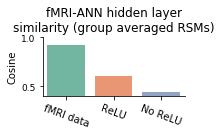

In [8]:
triu_ind = np.triu_indices(len(rsm_labels),k=1)
df_rsms = {}
df_rsms['Correlation'] = []
df_rsms['Cosine'] = []
df_rsms['Type'] = []

df_rsms['Correlation'].append(stats.pearsonr(rsm_true[triu_ind],ann_rsm[triu_ind])[0])
df_rsms['Cosine'].append(np.dot(rsm_true[triu_ind],ann_rsm[triu_ind])/(np.linalg.norm(rsm_true[triu_ind])*np.linalg.norm(ann_rsm[triu_ind])))
df_rsms['Type'].append('fMRI data')

triu_ind = np.triu_indices(len(rsm_labels),k=1)
df_rsms['Correlation'].append(stats.pearsonr(rsm_thresh[triu_ind],ann_rsm[triu_ind])[0])
df_rsms['Cosine'].append(np.dot(rsm_thresh[triu_ind],ann_rsm[triu_ind])/(np.linalg.norm(rsm_thresh[triu_ind])*np.linalg.norm(ann_rsm[triu_ind])))
df_rsms['Type'].append('ReLU')

df_rsms['Correlation'].append(stats.pearsonr(rsm_unthresh[triu_ind],ann_rsm[triu_ind])[0])
df_rsms['Cosine'].append(np.dot(rsm_unthresh[triu_ind],ann_rsm[triu_ind])/(np.linalg.norm(rsm_unthresh[triu_ind])*np.linalg.norm(ann_rsm[triu_ind])))
df_rsms['Type'].append('No ReLU')

df_rsms = pd.DataFrame(df_rsms)
# plt.figure(figsize=(3,2))
fig, ax = plt.subplots(figsize=(3, 2))
sns.barplot(x="Type",y='Cosine',data=df_rsms,palette='Set2',ax=ax)
plt.xticks(rotation=-20,fontsize=10)
plt.yticks(fontsize=9)
plt.ylabel('Cosine',fontsize=10)
plt.xlabel(None)
plt.title("fMRI-ANN hidden layer\nsimilarity (group averaged RSMs)",fontsize=12)
sns.despine()
plt.ylim([0.4,1.0])
plt.tight_layout()
# plt.savefig(figuredir + 'SimilarityToANNRSM_Group.pdf',transparent='True')

print('fMRI data cosine value:', df_rsms.loc[df_rsms.Type=='fMRI data'].Cosine.mean())
print('ReLU data cosine value:', df_rsms.loc[df_rsms.Type=='ReLU'].Cosine.mean())
print('No ReLU data cosine value:', df_rsms.loc[df_rsms.Type=='No ReLU'].Cosine.mean())

write = False
if write:
    with pd.ExcelWriter("../../data/NatComms_SourceData.xlsx",mode='a', engine="openpyxl") as writer:
        df_rsms.to_excel(writer,sheet_name='SFig5f')

Run group statistics
fMRI data versus Thresholded: t = 46.1096257290979 | p = 7.96408977702316e-67
ReLU vs. Non-ReLU: t = 14.880690287096378 | p = 1.4652595250989057e-26


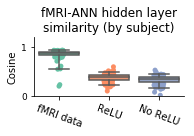

In [10]:
triu_ind = np.triu_indices(len(rsm_labels),k=1)
df_rsm_group = {}
df_rsm_group['Correlation'] = []
df_rsm_group['Cosine'] = []
df_rsm_group['Type'] = []
df_rsm_group['Subject'] = []

for s in range(true_activity.shape[0]):
    tmp_thresh = np.corrcoef(hidden_thresh[s])
    tmp_unthresh = np.corrcoef(hidden_unthresh[s])
    tmp_true = np.corrcoef(true_activity[s])

    df_rsm_group['Correlation'].append(stats.pearsonr(tmp_true[triu_ind],ann_rsm[triu_ind])[0])
    df_rsm_group['Cosine'].append(np.dot(tmp_true[triu_ind],ann_rsm[triu_ind])/(np.linalg.norm(tmp_true[triu_ind])*np.linalg.norm(ann_rsm[triu_ind])))
    df_rsm_group['Type'].append('fMRI data')
    df_rsm_group['Subject'].append(s)

    triu_ind = np.triu_indices(len(rsm_labels),k=1)
    df_rsm_group['Correlation'].append(stats.pearsonr(tmp_thresh[triu_ind],ann_rsm[triu_ind])[0])
    df_rsm_group['Cosine'].append(np.dot(tmp_thresh[triu_ind],ann_rsm[triu_ind])/(np.linalg.norm(tmp_thresh[triu_ind])*np.linalg.norm(ann_rsm[triu_ind])))
    df_rsm_group['Type'].append('ReLU')
    df_rsm_group['Subject'].append(s)

    df_rsm_group['Correlation'].append(stats.pearsonr(tmp_unthresh[triu_ind],ann_rsm[triu_ind])[0])
    df_rsm_group['Cosine'].append(np.dot(tmp_unthresh[triu_ind],ann_rsm[triu_ind])/(np.linalg.norm(tmp_unthresh[triu_ind])*np.linalg.norm(ann_rsm[triu_ind])))
    df_rsm_group['Type'].append('No ReLU')
    df_rsm_group['Subject'].append(s)

df_rsm_group = pd.DataFrame(df_rsm_group)
plt.figure(figsize=(3,2))
ax = sns.stripplot(x="Type",y='Cosine',data=df_rsm_group,palette='Set2',zorder=0)
sns.boxplot(x="Type",y='Cosine',data=df_rsm_group,palette='Set2',sym='',whis=[2.5,97.5],zorder=2)
plt.xticks(rotation=-20,fontsize=10)
plt.yticks(fontsize=9)
plt.ylabel('Cosine',fontsize=10)
plt.xlabel(None)
plt.title("fMRI-ANN hidden layer\nsimilarity (by subject)",fontsize=12)
sns.despine()
plt.ylim([0,1.2])
plt.tight_layout()
# plt.savefig(figuredir + 'SimilarityToANNRSM_Subjectwise.pdf',transparent='True')

print('Run group statistics')
t, p = stats.ttest_rel(df_rsm_group.loc[df_rsm_group.Type=='fMRI data'].Cosine.values,df_rsm_group.loc[df_rsm_group.Type=='ReLU'].Cosine.values)
print('fMRI data versus Thresholded: t =', t, '| p =', p)
t, p = stats.ttest_rel(df_rsm_group.loc[df_rsm_group.Type=='ReLU'].Cosine.values,df_rsm_group.loc[df_rsm_group.Type=='No ReLU'].Cosine.values)
print('ReLU vs. Non-ReLU: t =', t, '| p =', p)

write = False
if write:
    with pd.ExcelWriter("../../data/NatComms_SourceData.xlsx",mode='a', engine="openpyxl") as writer:
        df_rsm_group.to_excel(writer,sheet_name='SFig5g')

# Visualize RSMs, first computed per subject, then averaged

In [11]:
# rsm_thresh_all = []
# rsm_unthresh_all = []
# rsm_true_all = []
# for s in range(true_activity.shape[0]):
    
#     rsm_thresh_all.append(np.corrcoef(hidden_thresh[s]))
#     rsm_unthresh_all.append(np.corrcoef(hidden_unthresh[s]))
#     rsm_true_all.append(np.corrcoef(true_activity[s]))

# group_rsm_thresh = np.mean(rsm_thresh_all,axis=0)
# group_rsm_unthresh = np.mean(rsm_thresh_all,axis=0)
# group_rsm_true = np.mean(rsm_true_all,axis=0)
                        
# np.fill_diagonal(group_rsm_thresh,0)
# np.fill_diagonal(group_rsm_unthresh,0)
# np.fill_diagonal(group_rsm_true,0)

# plt.figure(figsize=(5,5))
# ax = sns.heatmap(group_rsm_thresh,square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
# ax.invert_yaxis()
# plt.ylabel('Task conditions',fontsize=9)
# plt.xlabel('Task conditions', fontsize=9)
# plt.title('Actflow-predicted hidden RSM\nthresholded')
# plt.xticks(np.arange(len(rsm_labels)), rsm_labels,rotation=-90)

# plt.figure(figsize=(5,5))
# ax = sns.heatmap(group_rsm_unthresh,square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
# ax.invert_yaxis()
# plt.ylabel('Task conditions',fontsize=9)
# plt.xlabel('Task conditions', fontsize=9)
# plt.title('Actflow-predicted hidden RSM\nunthresholded')

# plt.figure(figsize=(5,5))
# ax = sns.heatmap(group_rsm_true,square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
# ax.invert_yaxis()
# plt.ylabel('Task conditions',fontsize=9)
# plt.xlabel('Task conditions', fontsize=9)
# plt.title('True fMRI RSM')

# plt.figure(figsize=(5,5))
# ax = sns.heatmap(ann_rsm,square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
# ax.invert_yaxis()
# plt.ylabel('Task conditions',fontsize=9)
# plt.xlabel('Task conditions', fontsize=9)
# plt.title('ANN hidden layer')